In [83]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import xgboost as xgb
from sklearn.base import clone
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from pandas.errors import PerformanceWarning
import warnings

warnings.simplefilter(action="ignore", category=PerformanceWarning)
np.random.seed(2004)

In [51]:
data = pd.read_csv('weatherHistory.csv')
data.head(5)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [52]:
data = data[['Formatted Date', 'Temperature (C)']]
data

,Formatted Date,Temperature (C)
0,2006-04-01 00:00:00.000 +0200,9.472222
1,2006-04-01 01:00:00.000 +0200,9.355556
2,2006-04-01 02:00:00.000 +0200,9.377778
3,2006-04-01 03:00:00.000 +0200,8.288889
4,2006-04-01 04:00:00.000 +0200,8.755556
...,...,...
96448,2016-09-09 19:00:00.000 +0200,26.016667
96449,2016-09-09 20:00:00.000 +0200,24.583333
96450,2016-09-09 21:00:00.000 +0200,22.038889
96451,2016-09-09 22:00:00.000 +0200,21.522222


In [53]:
data.isna().sum()

,0
Formatted Date,0
Temperature (C),0


In [54]:
data.describe()

,Temperature (C)
count,96453.000000
mean,11.932678
std,9.551546
min,-21.822222
25%,4.688889
50%,12.000000
75%,18.838889
max,39.905556


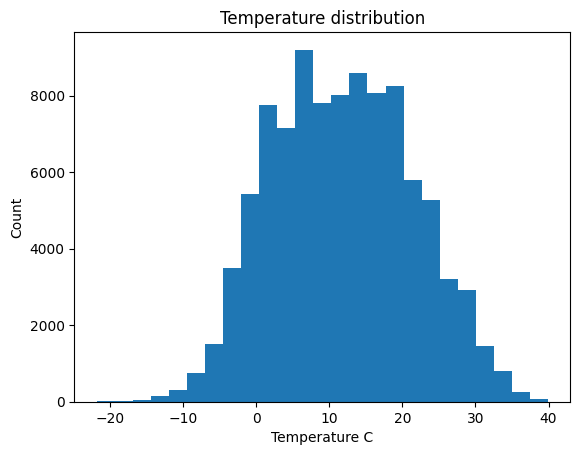

In [55]:
plt.hist(data['Temperature (C)'], bins=25)
plt.ylabel('Count')
plt.xlabel('Temperature C')
plt.title('Temperature distribution')
plt.show()

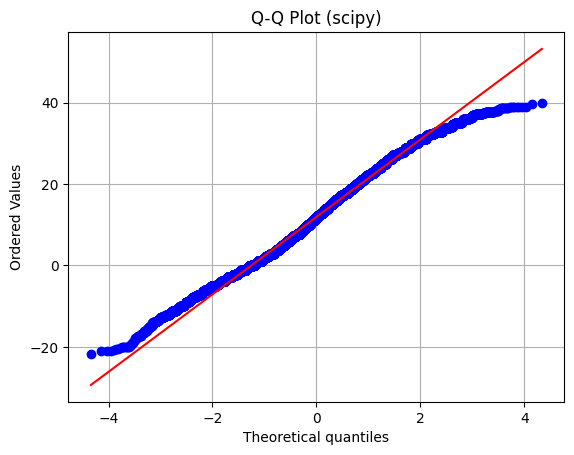

In [56]:
stats.probplot(data['Temperature (C)'], dist="norm", plot=plt)
plt.title("Q-Q Plot (scipy)")
plt.grid(True)
plt.show()


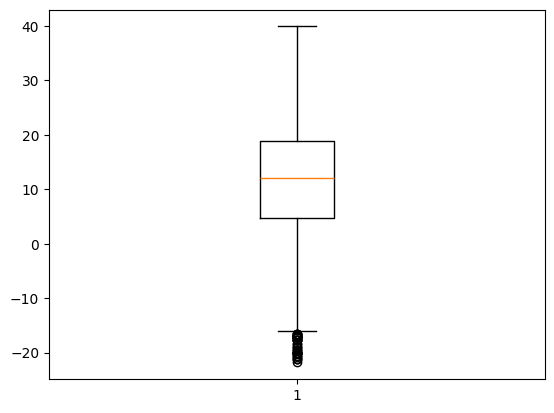

In [57]:
plt.boxplot(data['Temperature (C)'])
plt.show()

Что можно сказать о данных:
- Если медиана смещена ближе к одному краю коробки — распределение асимметрично.
- Если усы сильно отличаются по длине — возможна асимметрия или наличие экстремальных значений.
- Много выбросов — может говорить о шуме в данных, ошибках измерения или наличии редких случаев.


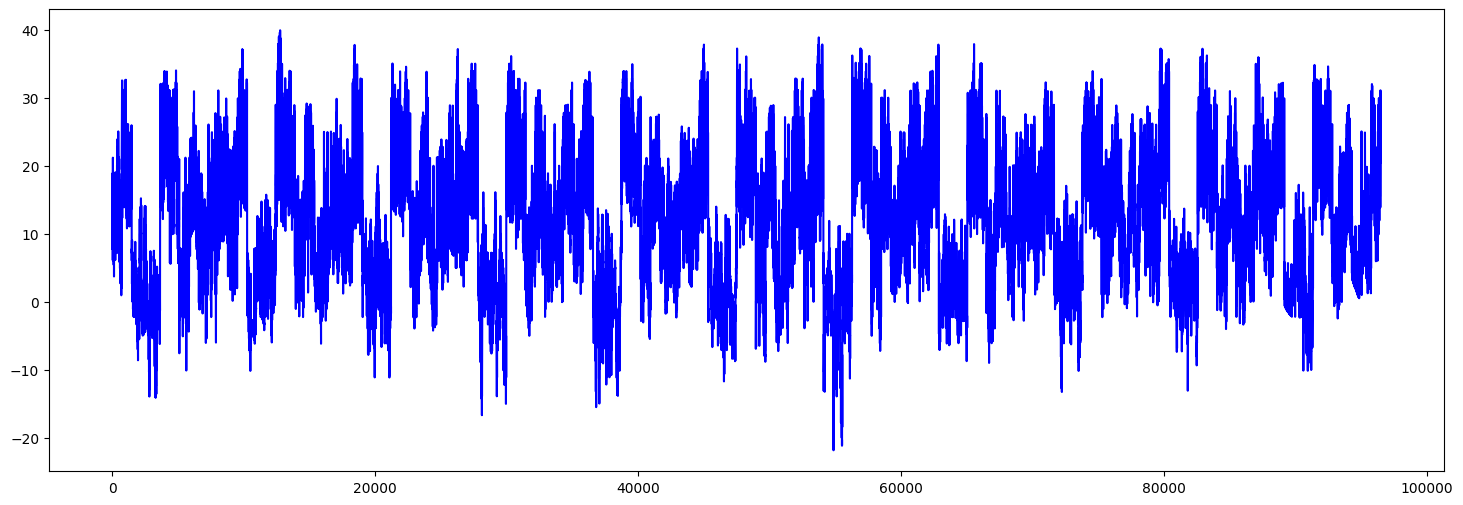

In [58]:
plt.figure(figsize=(18,6))
plt.plot(data['Temperature (C)'], color = 'blue')
plt.show()

#Генерация признаков

In [59]:
def create_features(temp, window_sizes=[2, 3, 5, 8, 10, 11, 12, 13, 15, 20, 25, 30]):
    """Создание признаков для временного ряда без утечки данных"""
    features = pd.DataFrame()
    temp_series = temp['Temperature (C)']

    for lag in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25, 30]:
        features[f'lag_{lag}'] = temp_series.shift(lag)

    shifted_series = temp_series.shift(1)
    for window in window_sizes:
        features[f'ma_{window}'] = shifted_series.rolling(window).mean()
        features[f'std_{window}'] = shifted_series.rolling(window).std()
        features[f'med_{window}'] = shifted_series.rolling(window).median()
        features[f'min_{window}'] = shifted_series.rolling(window).min()
        features[f'var_{window}'] = shifted_series.rolling(window).var()
        if window > 3:
            features[f'skew_{window}'] = shifted_series.rolling(window).skew()
            features[f'kurt_{window}'] = shifted_series.rolling(window).kurt()
        features[f'q25_{window}'] = shifted_series.rolling(window).quantile(0.25)
        features[f'q5_{window}'] = shifted_series.rolling(window).quantile(0.5)
        features[f'q75_{window}'] = shifted_series.rolling(window).quantile(0.75)
        features[f'iqr_{window}'] = features[f'q75_{window}'] - features[f'q25_{window}']

        features[f'ema0.1_{window}'] = shifted_series.ewm(alpha=0.1, adjust=False).mean()
        features[f'ema0.2_{window}'] = shifted_series.ewm(alpha=0.2, adjust=False).mean()
        features[f'ema0.3_{window}'] = shifted_series.ewm(alpha=0.3, adjust=False).mean()
        features[f'ema0.5_{window}'] = shifted_series.ewm(alpha=0.5, adjust=False).mean()
        features[f'ema0.7_{window}'] = shifted_series.ewm(alpha=0.7, adjust=False).mean()

    delta = temp_series.diff()
    gain = delta.where(delta > 0, 0).shift(1).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).shift(1).rolling(14).mean()
    rs = gain / loss
    features['rsi'] = 100 - (100 / (1 + rs))

    prev_temp = temp_series.shift(1)
    tr = (temp_series - prev_temp).abs()
    atr = tr.shift(1).rolling(window=14).mean()
    features['vr'] = tr / atr

    return features.dropna()



print(f"Форма исходных данных: {data.shape}")
print(f"Тип данных: {type(data)}")

features_df = create_features(data)
print(f"\n Создано {len(features_df.columns)} признаков")
print(f"Размер данных: {features_df.shape}")
print(f"Признаки: {list(features_df.columns)}")

Форма исходных данных: (96453, 2)
Тип данных: <class 'pandas.core.frame.DataFrame'>

 Создано 205 признаков
Размер данных: (96423, 205)
Признаки: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_13', 'lag_15', 'lag_20', 'lag_25', 'lag_30', 'ma_2', 'std_2', 'med_2', 'min_2', 'var_2', 'q25_2', 'q5_2', 'q75_2', 'iqr_2', 'ema0.1_2', 'ema0.2_2', 'ema0.3_2', 'ema0.5_2', 'ema0.7_2', 'ma_3', 'std_3', 'med_3', 'min_3', 'var_3', 'q25_3', 'q5_3', 'q75_3', 'iqr_3', 'ema0.1_3', 'ema0.2_3', 'ema0.3_3', 'ema0.5_3', 'ema0.7_3', 'ma_5', 'std_5', 'med_5', 'min_5', 'var_5', 'skew_5', 'kurt_5', 'q25_5', 'q5_5', 'q75_5', 'iqr_5', 'ema0.1_5', 'ema0.2_5', 'ema0.3_5', 'ema0.5_5', 'ema0.7_5', 'ma_8', 'std_8', 'med_8', 'min_8', 'var_8', 'skew_8', 'kurt_8', 'q25_8', 'q5_8', 'q75_8', 'iqr_8', 'ema0.1_8', 'ema0.2_8', 'ema0.3_8', 'ema0.5_8', 'ema0.7_8', 'ma_10', 'std_10', 'med_10', 'min_10', 'var_10', 'skew_10', 'kurt_10', 'q25_10', 'q5_10', 'q75_10', 'iqr_10', 'ema0.

In [60]:
features_df.max().sort_values(ascending=False)

,0
var_2,450.000000
var_20,344.983467
var_25,333.348973
var_15,317.719999
var_13,302.968642
...,...
skew_12,3.463790
skew_11,3.316393
skew_10,3.162278
skew_8,2.828486


In [61]:
target = data['Temperature (C)'].shift(-1)

valid_indices = features_df.index.intersection(target.dropna().index)
X = features_df.loc[valid_indices].values
y = target.loc[valid_indices].values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

X shape: (96422, 205)
y shape: (96422,)
Train: (77137, 205), Test: (19285, 205)


Шаг 1: добавлен признак 0, R² = 0.9336
Шаг 2: добавлен признак 34, R² = 0.9517
Шаг 3: добавлен признак 12, R² = 0.9629
Шаг 4: добавлен признак 13, R² = 0.9652
Шаг 5: добавлен признак 141, R² = 0.9656
Шаг 6: добавлен признак 171, R² = 0.9660
Шаг 7: добавлен признак 155, R² = 0.9667
Шаг 8: добавлен признак 175, R² = 0.9668
Шаг 9: добавлен признак 158, R² = 0.9671
Шаг 10: добавлен признак 148, R² = 0.9672
Шаг 11: добавлен признак 174, R² = 0.9673
Шаг 12: добавлен признак 191, R² = 0.9675
Шаг 13: добавлен признак 204, R² = 0.9676
Шаг 14: добавлен признак 64, R² = 0.9677
Шаг 15: добавлен признак 162, R² = 0.9677
Шаг 16: добавлен признак 196, R² = 0.9678
Шаг 17: добавлен признак 193, R² = 0.9678
Шаг 18: добавлен признак 62, R² = 0.9679
Шаг 19: добавлен признак 82, R² = 0.9680
Шаг 20: добавлен признак 2, R² = 0.9681
Шаг 21: добавлен признак 9, R² = 0.9681


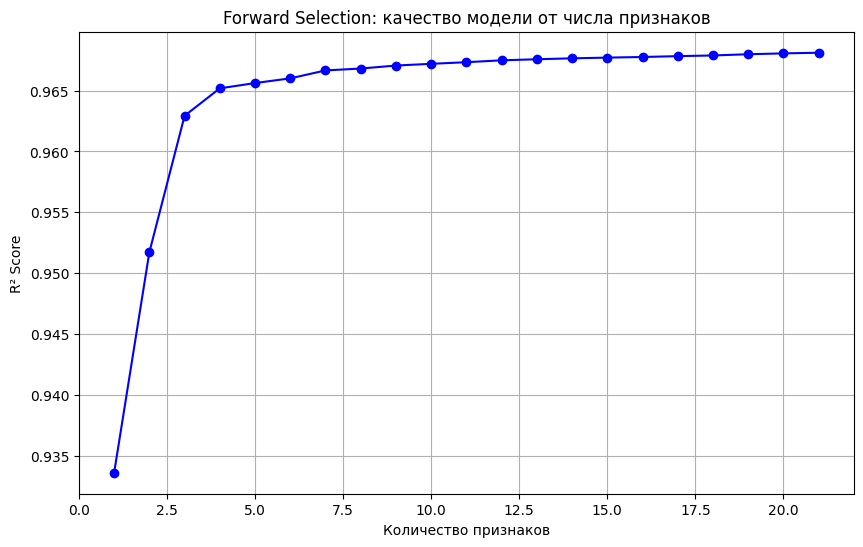


Оптимальное количество признаков: 21


In [62]:
def forward_selection(X_train, y_train, X_test, y_test, max_features=21):
    """Forward Selection для отбора признаков"""

    n_features = X_train.shape[1]
    selected_features = []
    remaining_features = list(range(n_features))
    scores = []

    for step in range(min(max_features, n_features)):
        best_score = -np.inf
        best_feature = None

        for feature in remaining_features:
            current_features = selected_features + [feature]

            model = LinearRegression()
            model.fit(X_train[:, current_features], y_train)

            score = model.score(X_test[:, current_features], y_test)

            if score > best_score:
                best_score = score
                best_feature = feature

        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        scores.append(best_score)

        print(f"Шаг {step+1}: добавлен признак {best_feature}, R² = {best_score:.4f}")

    return selected_features, scores

selected_features, selection_scores = forward_selection(
    X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled
)


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(selection_scores)+1), selection_scores, 'bo-')
plt.xlabel('Количество признаков')
plt.ylabel('R² Score')
plt.title('Forward Selection: качество модели от числа признаков')
plt.grid(True)
plt.show()

optimal_n_features = np.argmax(selection_scores) + 1
print(f"\nОптимальное количество признаков: {optimal_n_features}")


#Линейная Регрессия

In [95]:
ridge = Ridge()
tss_ridge = TimeSeriesSplit(n_splits=5)
params_ridge = {'alpha':np.logspace(-4, 4, 50)}
grid_ridge = GridSearchCV(estimator=ridge, param_grid=params_ridge, cv = tss_ridge)
grid_ridge.fit(X_train_scaled[:, selected_features], y_train_scaled)
best_ridge = grid_ridge.best_estimator_
print(f'Alfa для модели: {grid_ridge.best_params_.get('alpha')}')
y_pred_ridge = best_ridge.predict(X_test_scaled[:, selected_features])

r2_ridge = r2_score(y_test_scaled, y_pred_ridge)
mse_ridge = mean_squared_error(y_test_scaled, y_pred_ridge)
print(f'Оценка качества для Ridge модели: \nR² - {r2_ridge:.4f} \nMSE - {mse_ridge:.4f}')


Alfa для модели: 0.5689866029018293
Оценка качества для Ridge модели: 
R² - 0.9681 
MSE - 0.0274


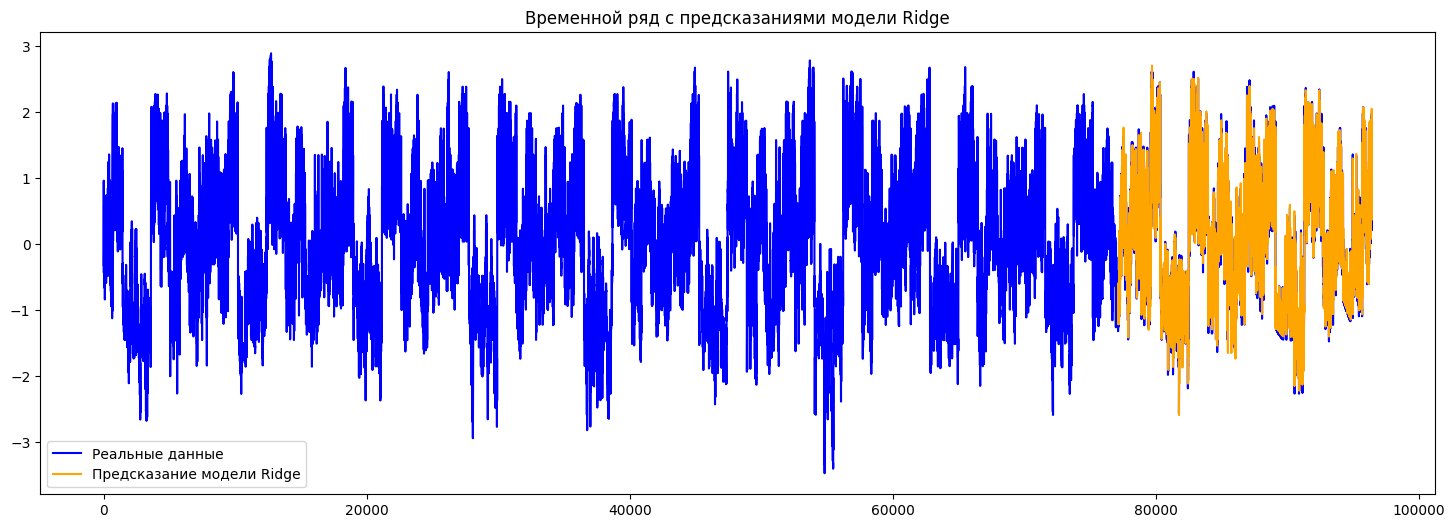

In [64]:
plt.figure(figsize=(18,6))

plt.plot(np.arange(len(np.concatenate((y_train_scaled, y_test_scaled)))),np.concatenate((y_train_scaled, y_test_scaled)), color = 'blue', label='Реальные данные')
plt.plot(np.arange(len(np.concatenate((y_train_scaled, y_test_scaled))))[-len(y_pred_ridge):],np.concatenate((y_train_scaled, y_pred_ridge))[-len(y_pred_ridge):], color = 'orange', label='Предсказание модели Ridge')
plt.legend()
plt.title('Временной ряд с предсказаниями модели Ridge')
plt.show()

# Gradient Boosting Regressor

In [65]:
cv_xgb = TimeSeriesSplit(n_splits=5)
params_xgb = {
    'n_estimators' : [100, 300, 500, 1000],
    'max_depth' : [3, 5, 7, 10],
    'learning_rate' : [0.01, 0.05, 0.1, 0.2],
    'subsample' : [0.8, 0.9, 1.0]
    }

early_stop = xgb.callback.EarlyStopping(
    rounds=3, metric_name='r2_score', data_name='validation_0', save_best=True
)
xgb_reg = xgb.XGBRegressor(tree_method="hist", callbacks=[early_stop])

param_grid = ParameterGrid(params_xgb)

best_score = -np.inf
best_model = None
best_params = None

for params in param_grid:
    fold_scores = []
    for train_idx, val_idx in cv_xgb.split(X_train_scaled):
        X_tr = X_train_scaled[train_idx][:, selected_features]
        y_tr = y_train_scaled[train_idx]
        X_val = X_train_scaled[val_idx][:, selected_features]
        y_val = y_train_scaled[val_idx]

        model = xgb.XGBRegressor(**params, tree_method="hist", early_stopping_rounds=3)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

        preds = model.predict(X_val)
        fold_scores.append(r2_score(y_val, preds))

    avg_score = np.mean(fold_scores)
    if avg_score > best_score:
        best_score = avg_score
        best_model = model
        best_params = params

print(f"Лучшие параметры: {best_params}")


Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000, 'subsample': 0.8}


R² score для XGBRegressor: 0.9775 
MSE: 0.0193



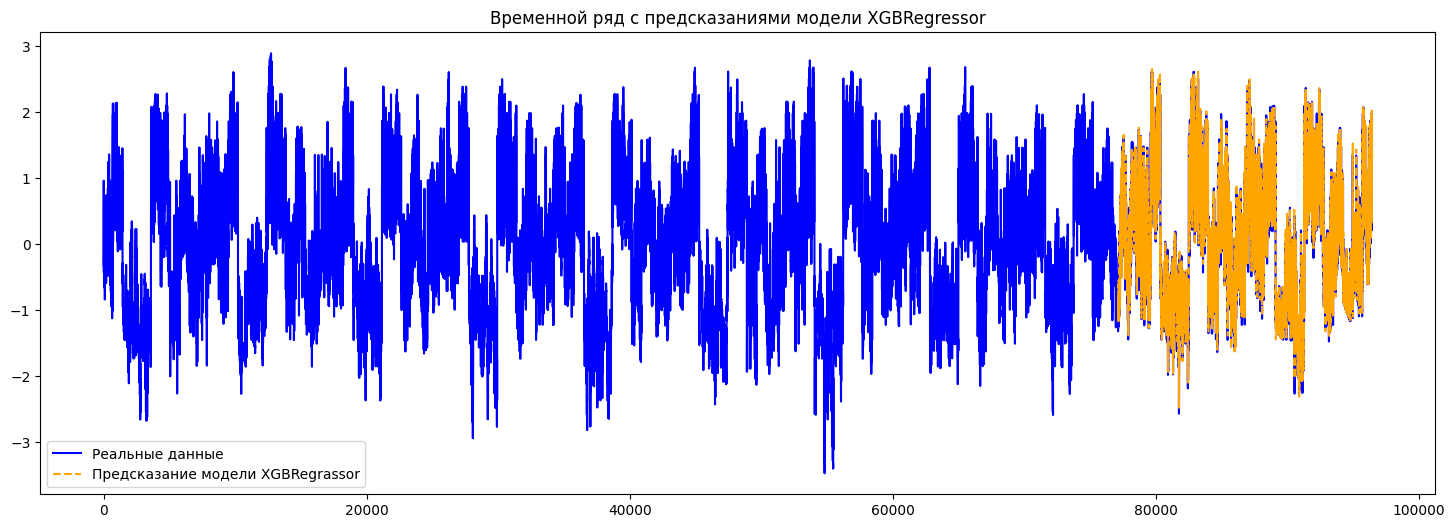

In [66]:
y_pred_xgb = best_model.predict(X_test_scaled[:,selected_features])
r2_xgb = r2_score(y_test_scaled, y_pred_xgb)
mse_xgb = mean_squared_error(y_test_scaled, y_pred_xgb)
print(f'R² score для XGBRegressor: {r2_xgb:.4f} \nMSE: {mean_squared_error(y_test_scaled, y_pred_xgb):.4f}\n')

plt.figure(figsize=(18,6))

plt.plot(np.arange(len(np.concatenate((y_train_scaled, y_test_scaled)))),np.concatenate((y_train_scaled, y_test_scaled)), color = 'blue', label='Реальные данные')
plt.plot(np.arange(len(np.concatenate((y_train_scaled, y_test_scaled))))[-len(y_pred_xgb):],np.concatenate((y_train_scaled, y_pred_xgb))[-len(y_pred_xgb):], color = 'orange',linestyle='--' ,label='Предсказание модели XGBRegrassor')
plt.legend()
plt.title('Временной ряд с предсказаниями модели XGBRegressor')
plt.show()

#LSTM

In [84]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Память GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    torch.backends.cudnn.benchmark = True
    torch.cuda.manual_seed(42)
else:
    print("⚠️  GPU недоступно, используется CPU")

plt.style.use('default')
random.seed(2004)
torch.manual_seed(2004)
torch.cuda.manual_seed(2004)


print("Библиотеки загружены и GPU настроено!")

GPU: Tesla T4
Память GPU: 14.7 GB
Библиотеки загружены и GPU настроено!


In [85]:
def create_sequences(data, seq_length=30):
    """
    Создание последовательностей для RNN

    Зачем это нужно:
    RNN работают с последовательностями фиксированной длины, но наши данные -
    это один длинный временной ряд. Мы создаем "скользящее окно":

    Пример: data = [100, 102, 101, 105, 107, 103], seq_length = 3
    Результат:
    X[0] = [100, 102, 101] → y[0] = 105
    X[1] = [102, 101, 105] → y[1] = 107
    X[2] = [101, 105, 107] → y[2] = 103

    Это позволяет RNN учиться предсказывать следующую точку на основе истории.
    """
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i] if len(data[i].shape) == 0 else data[i, 0])
    return np.array(X), np.array(y)

seq_length = 10
optimal_features = selected_features[:optimal_n_features]

X_lstm_train, y_lstm_train = create_sequences(X_train_scaled[:, optimal_features], seq_length)
X_lstm_test, y_lstm_test = create_sequences(X_test_scaled[:, optimal_features], seq_length)

print(f"LSTM данные - Train: {X_lstm_train.shape}, Test: {X_lstm_test.shape}")


LSTM данные - Train: (77127, 10, 21), Test: (19275, 10, 21)


In [93]:
def train_pytorch_model(model, X_train, y_train, X_test, y_test, epochs=100):
    """Обучение PyTorch модели с GPU поддержкой"""
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.FloatTensor(y_test).to(device)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        train_pred = model(X_train_tensor)
        train_loss = criterion(train_pred.squeeze(), y_train_tensor)
        train_loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            test_pred = model(X_test_tensor)
            test_loss = criterion(test_pred.squeeze(), y_test_tensor)

        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())

        if epoch % 20 == 0:
            print(f'Epoch {epoch}, Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

            if torch.cuda.is_available():
                print(f'GPU память: {torch.cuda.memory_allocated() / 1024**2:.0f} MB')

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return train_losses, test_losses

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, dropout=0.25)
        self.dp = nn.Dropout(p=0.25)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        dp_out = self.dp(lstm_out)
        output = self.fc(dp_out[:, -1, :])
        return output

print("\nОбучаем LSTM...")
lstm_model = SimpleLSTM(optimal_n_features, hidden_size=100)
lstm_train_losses, lstm_test_losses = train_pytorch_model(lstm_model, X_lstm_train, y_lstm_train, X_lstm_test, y_lstm_test, epochs=100)

lstm_model.eval()
with torch.no_grad():
    lstm_pred = lstm_model(torch.FloatTensor(X_lstm_test).to(device))
    lstm_r2 = r2_score(y_lstm_test, lstm_pred.squeeze().cpu().numpy())

print(f"LSTM R²: {lstm_r2:.4f}")
print("\nОбучение завершено!")



Обучаем LSTM...
Epoch 0, Train Loss: 1.0652, Test Loss: 0.8538
GPU память: 467 MB
Epoch 20, Train Loss: 0.2267, Test Loss: 0.1937
GPU память: 467 MB
Epoch 40, Train Loss: 0.1205, Test Loss: 0.0962
GPU память: 467 MB
Epoch 60, Train Loss: 0.0804, Test Loss: 0.0597
GPU память: 467 MB
Epoch 80, Train Loss: 0.0603, Test Loss: 0.0427
GPU память: 467 MB
LSTM R²: 0.9600

Обучение завершено!


Сравнение моделей:



,Model,R2_Score,MSE,Parameters
0,Linear Regression,0.968105,0.027406,22
1,XGBRegressor,0.977502,0.019332,1000
2,LSTM,0.960019,0.034354,130101


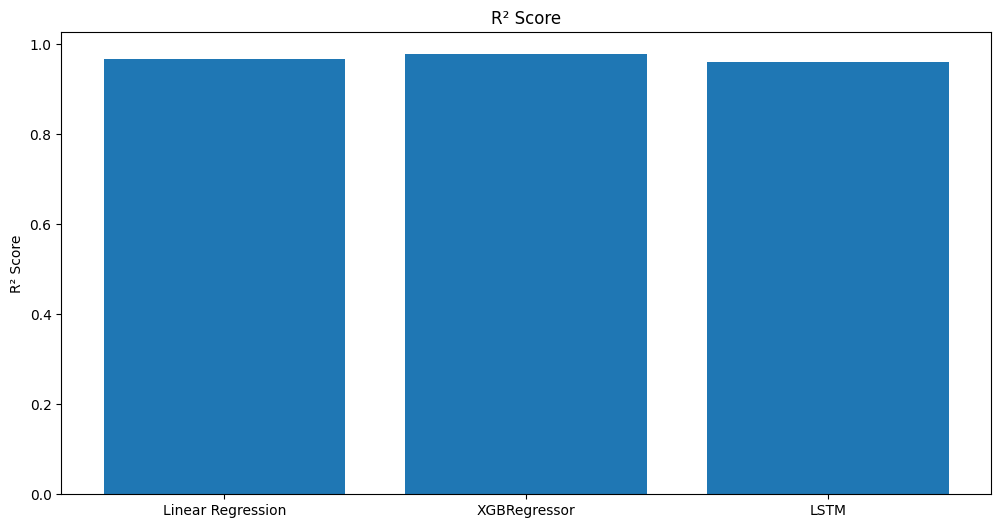

In [116]:
lstm_mse = mean_squared_error(y_lstm_test, lstm_pred.squeeze().cpu().numpy())

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

lstm_params = count_parameters(lstm_model)

results = {
    'Model': ['Linear Regression', 'XGBRegressor', 'LSTM'],
    'R2_Score': [r2_ridge, r2_xgb, lstm_r2],
    'MSE': [mse_ridge, mse_xgb, lstm_mse],
    'Parameters': [optimal_n_features + 1, best_model.n_estimators, lstm_params]
}

results_df = pd.DataFrame(results)
print("Сравнение моделей:\n")
display(results_df)
print('\n')

plt.figure(figsize=(12,6))
plt.bar(results['Model'], results['R2_Score'])
plt.title('R² Score')
plt.ylabel('R² Score')

plt.show()

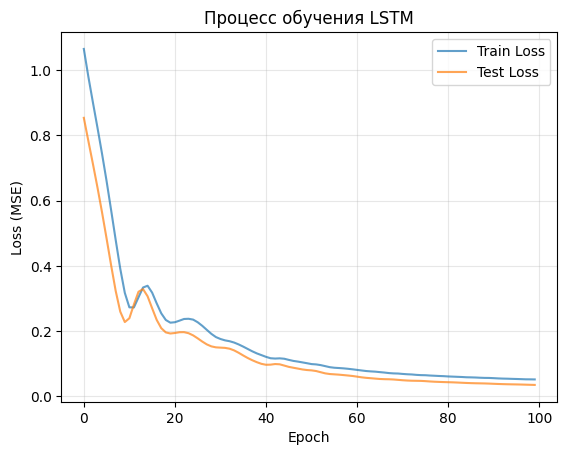


Выводы:
1. Использовано 21 из 205 признаков
2. Лучшая модель: XGBRegressor (R² = 0.9775)
3. Forward Selection помог найти оптимальный набор признаков
4. Количество параметров: Ridge (22), XGBRegressor (1000), LSTM (130101)


In [118]:
plt.plot(lstm_train_losses, label='Train Loss', alpha=0.7)
plt.plot(lstm_test_losses, label='Test Loss', alpha=0.7)
plt.title('Процесс обучения LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

print("\nВыводы:")
print(f"1. Использовано {optimal_n_features} из {features_df.shape[1]} признаков")
print(f"2. Лучшая модель: {results['Model'][np.argmax(results['R2_Score'])]} (R² = {max(results['R2_Score']):.4f})")
print(f"3. Forward Selection помог найти оптимальный набор признаков")
print(f"4. Количество параметров: Ridge ({results['Parameters'][0]}), XGBRegressor ({results['Parameters'][1]}), LSTM ({results['Parameters'][2]})")